## NUTS sampler using Pymc3. ODE integration using scipy (Pymc3 DifferentialEquations)

### Single cycle transporter

#### import modules, update pymc3 ode class to include lower tolerances, define reaction cycle models, and generate synthetic data

In [1]:
import numpy as np
import pymc3 as pm
from pymc3.ode import DifferentialEquation
import scipy
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
import theano 
import arviz as az
floatX = theano.config.floatX


class DifferentialEquationWTol(DifferentialEquation):
    def _simulate(self, y0, theta):
        # Initial condition comprised of state initial conditions and raveled sensitivity matrix
        s0 = np.concatenate([y0, self._sens_ic])
        # perform the integration
        sol = scipy.integrate.odeint(
            func=self._system, y0=s0, t=self._augmented_times, args=(np.concatenate([y0, theta]),), 
        ).astype(floatX)
        # The solution
        y = sol[1:, : self.n_states]
        print('setting lower tolerance')
        # The sensitivities, reshaped to be a sequence of matrices
        sens = sol[1:, self.n_states :].reshape(self.n_times, self.n_states, self.n_p)
        return y, sens




def transporter_1c(y, t, theta, b):
    """ Single cycle model for a 1:1 secondary-active membrane transporter. 
    Assumes a fixed external concentration of the ion and substrate (e.g. experimental buffer solution)
    see: https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html 

    Args:
        y (numpy array): model state concentrations
        t (float): time point for integration
        theta (numpy array): model reaction rate constants
        b (numpy array): concentrations for the fixed external buffer solution (ion_out, substrate_out)

    Returns:
        (numpy array): integrated state concetrations at time point t (same order as y)
    """

    ### compartment size (in L)
    vol = 1
    v=1

    ### model parameters - reaction rate constants (in 1/s and 1/(Ms))
    rxn1_k1 = 0
    rxn1_k2 = 0
    rxn2_k1 = 10**theta[0]  # H on rate
    rxn2_k2 = 10**theta[1]  # H off rate
    rxn3_k1 = 10**theta[2]  # S off rate
    rxn3_k2 = 10**theta[3]  # S on rate
    rxn4_k1 = 10**theta[4]  # conf rate
    rxn4_k2 = 10**theta[5]  # conf rate
    rxn5_k1 = 0
    rxn5_k2 = 0
    rxn6_k1 = 10**theta[6]  # conf rate
    rxn6_k2 = 10**theta[7]  # conf rate
    rxn7_k1 = 0
    rxn7_k2 = 0
    rxn8_k1 = 0
    rxn8_k2 = 0
    rxn9_k1 = 0
    rxn9_k2 = 0
    rxn10_k1 = 0
    rxn10_k2 = 0
    rxn11_k1 = 10**theta[8]  # S on rate
    rxn11_k2 = 10**theta[9]  # S off rate
    rxn12_k1 = 10**theta[10]  # H off rate
    rxn12_k2 = (rxn2_k1*rxn3_k1*rxn4_k1*rxn6_k1*rxn11_k1*rxn12_k1)/(rxn2_k2*rxn3_k2*rxn4_k2*rxn6_k2*rxn11_k2)  # H on rate (cycle constraint)
  
    ### model state concentrations (in M)
    H_out = b[0]  # constant external ion concentration (e.g. buffer solution) 
    S_out = b[1]  # constant external substrate concentration (e.g. buffer solution) 
    
    H_in = y[0]  # internal ion concentration
    S_in = y[1]  # internal substrate concentation
    OF = y[2]  # fully unbound outward-facing transporter 
    IF = y[3]  # fully unbound inward-facing transporter
    OF_Hb = y[4]  # ion-bound only outward-facing transporter
    IF_Hb = y[5]  # ion-bound only inward-facing transporter
    OF_Sb = y[6]  # substrate-bound only outward-facing transporter
    IF_Sb = y[7]  # substrate-bound only inward-facing transporter
    OF_Hb_Sb = y[8]  # ion and substrate bound outward-facing transporter
    IF_Hb_Sb = y[9]  # ion and substrate bound inward-facing transporter

           
    ### reaction equations (from Tellurium)       
    vrxn1 = vol*(rxn1_k1*IF-rxn1_k2*OF)
    vrxn2 = vol*(rxn2_k1*OF*H_out-rxn2_k2*OF_Hb)
    vrxn3 = vol*(rxn3_k1*OF_Sb-rxn3_k2*OF*S_out)
    vrxn4 = vol*(rxn4_k1*OF_Hb-rxn4_k2*IF_Hb)
    vrxn5 = vol*(rxn5_k1*OF_Hb_Sb-rxn5_k2*OF_Hb*S_out)
    vrxn6 = vol*(rxn6_k1*IF_Sb-rxn6_k2*OF_Sb)
    vrxn7 = vol*(rxn7_k1*OF_Sb*H_out-rxn7_k2*OF_Hb_Sb)
    vrxn8 = vol*(rxn8_k1*OF_Hb_Sb-rxn8_k2*IF_Hb_Sb)
    vrxn9 = vol*(rxn9_k1*IF_Hb-rxn9_k2*IF*H_in)
    vrxn10 = vol*(rxn10_k1*IF*S_in-rxn10_k2*IF_Sb)
    vrxn11 = vol*(rxn11_k1*IF_Hb*S_in-rxn11_k2*IF_Hb_Sb)
    vrxn12 = vol*(rxn12_k1*IF_Hb_Sb-rxn12_k2*IF_Sb*H_in)

    ### ODE equations (from Tellurium)
    dOF_dt = v*(vrxn1 - vrxn2 + vrxn3)
    dOF_Hb_dt = v*(vrxn2 - vrxn4 + vrxn5)
    dIF_Hb_dt = v*(vrxn4 - vrxn9 - vrxn11)
    dS_in_dt = v*(-vrxn10 - vrxn11)
    dIF_Hb_Sb_dt = v*(vrxn8 + vrxn11 - vrxn12)
    dH_in_dt = v*(vrxn9 + vrxn12)
    dIF_Sb_dt = v*(-vrxn6 + vrxn10 + vrxn12)
    dOF_Sb_dt = v*(-vrxn3 + vrxn6 - vrxn7)
    dIF_dt = v*(-vrxn1 + vrxn9 - vrxn10)
    dOF_Hb_Sb_dt = v*(-vrxn5 + vrxn7 - vrxn8)
    ODE_list = [
        dH_in_dt,
        dS_in_dt,
        dOF_dt,
        dIF_dt,
        dOF_Hb_dt, 
        dIF_Hb_dt,
        dOF_Sb_dt,
        dIF_Sb_dt, 
        dOF_Hb_Sb_dt,
        dIF_Hb_Sb_dt,   
    ]
    return np.stack(ODE_list)


def transporter_s1(y, t, theta):
    """ Single cycle model for a 1:1 secondary-active membrane transporter. 
    Assumes a fixed external concentration of the ion and substrate (e.g. experimental buffer solution)
    see: https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html 

    Args:
        y (numpy array): model state concentrations
        t (float): time point for integration
        theta (numpy array): model reaction rate constants
        b (numpy array): concentrations for the fixed external buffer solution (ion_out, substrate_out)

    Returns:
        (numpy array): integrated state concetrations at time point t (same order as y)
    """

    ### compartment size (in L)
    vol = 1
    v=1

    ### model parameters - reaction rate constants (in 1/s and 1/(Ms))
    rxn1_k1 = 0
    rxn1_k2 = 0
    rxn2_k1 = 10**theta[0]  # H on rate
    rxn2_k2 = 10**theta[1]  # H off rate
    rxn3_k1 = 10**theta[2]  # S off rate
    rxn3_k2 = 10**theta[3]  # S on rate
    rxn4_k1 = 10**theta[4]  # conf rate
    rxn4_k2 = 10**theta[5]  # conf rate
    rxn5_k1 = 0
    rxn5_k2 = 0
    rxn6_k1 = 10**theta[6]  # conf rate
    rxn6_k2 = 10**theta[7]  # conf rate
    rxn7_k1 = 0
    rxn7_k2 = 0
    rxn8_k1 = 0
    rxn8_k2 = 0
    rxn9_k1 = 0
    rxn9_k2 = 0
    rxn10_k1 = 0
    rxn10_k2 = 0
    rxn11_k1 = 10**theta[8]  # S on rate
    rxn11_k2 = 10**theta[9]  # S off rate
    rxn12_k1 = 10**theta[10]  # H off rate
    rxn12_k2 = (rxn2_k1*rxn3_k1*rxn4_k1*rxn6_k1*rxn11_k1*rxn12_k1)/(rxn2_k2*rxn3_k2*rxn4_k2*rxn6_k2*rxn11_k2)  # H on rate (cycle constraint)
  
    ### model state concentrations (in M)
    H_out = 1e-7  # constant external ion concentration (e.g. buffer solution) 
    S_out = 0.001  # constant external substrate concentration (e.g. buffer solution) 
    
    H_in = y[0]  # internal ion concentration
    S_in = y[1]  # internal substrate concentation
    OF = y[2]  # fully unbound outward-facing transporter 
    IF = y[3]  # fully unbound inward-facing transporter
    OF_Hb = y[4]  # ion-bound only outward-facing transporter
    IF_Hb = y[5]  # ion-bound only inward-facing transporter
    OF_Sb = y[6]  # substrate-bound only outward-facing transporter
    IF_Sb = y[7]  # substrate-bound only inward-facing transporter
    OF_Hb_Sb = y[8]  # ion and substrate bound outward-facing transporter
    IF_Hb_Sb = y[9]  # ion and substrate bound inward-facing transporter

           
    ### reaction equations (from Tellurium)       
    vrxn1 = vol*(rxn1_k1*IF-rxn1_k2*OF)
    vrxn2 = vol*(rxn2_k1*OF*H_out-rxn2_k2*OF_Hb)
    vrxn3 = vol*(rxn3_k1*OF_Sb-rxn3_k2*OF*S_out)
    vrxn4 = vol*(rxn4_k1*OF_Hb-rxn4_k2*IF_Hb)
    vrxn5 = vol*(rxn5_k1*OF_Hb_Sb-rxn5_k2*OF_Hb*S_out)
    vrxn6 = vol*(rxn6_k1*IF_Sb-rxn6_k2*OF_Sb)
    vrxn7 = vol*(rxn7_k1*OF_Sb*H_out-rxn7_k2*OF_Hb_Sb)
    vrxn8 = vol*(rxn8_k1*OF_Hb_Sb-rxn8_k2*IF_Hb_Sb)
    vrxn9 = vol*(rxn9_k1*IF_Hb-rxn9_k2*IF*H_in)
    vrxn10 = vol*(rxn10_k1*IF*S_in-rxn10_k2*IF_Sb)
    vrxn11 = vol*(rxn11_k1*IF_Hb*S_in-rxn11_k2*IF_Hb_Sb)
    vrxn12 = vol*(rxn12_k1*IF_Hb_Sb-rxn12_k2*IF_Sb*H_in)

    ### ODE equations (from Tellurium)
    dOF_dt = v*(vrxn1 - vrxn2 + vrxn3)
    dOF_Hb_dt = v*(vrxn2 - vrxn4 + vrxn5)
    dIF_Hb_dt = v*(vrxn4 - vrxn9 - vrxn11)
    dS_in_dt = v*(-vrxn10 - vrxn11)
    dIF_Hb_Sb_dt = v*(vrxn8 + vrxn11 - vrxn12)
    dH_in_dt = v*(vrxn9 + vrxn12)
    dIF_Sb_dt = v*(-vrxn6 + vrxn10 + vrxn12)
    dOF_Sb_dt = v*(-vrxn3 + vrxn6 - vrxn7)
    dIF_dt = v*(-vrxn1 + vrxn9 - vrxn10)
    dOF_Hb_Sb_dt = v*(-vrxn5 + vrxn7 - vrxn8)
    ODE_list = [
        dH_in_dt,
        dS_in_dt,
        dOF_dt,
        dIF_dt,
        dOF_Hb_dt, 
        dIF_Hb_dt,
        dOF_Sb_dt,
        dIF_Sb_dt, 
        dOF_Hb_Sb_dt,
        dIF_Hb_Sb_dt,   
    ]
    return ODE_list

def transporter_s2(y, t, theta):
    """ Single cycle model for a 1:1 secondary-active membrane transporter. 
    Assumes a fixed external concentration of the ion and substrate (e.g. experimental buffer solution)
    see: https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html 

    Args:
        y (numpy array): model state concentrations
        t (float): time point for integration
        theta (numpy array): model reaction rate constants
        b (numpy array): concentrations for the fixed external buffer solution (ion_out, substrate_out)

    Returns:
        (numpy array): integrated state concetrations at time point t (same order as y)
    """

    ### compartment size (in L)
    vol = 1
    v=1

    ### model parameters - reaction rate constants (in 1/s and 1/(Ms))
    rxn1_k1 = 0
    rxn1_k2 = 0
    rxn2_k1 = 10**theta[0]  # H on rate
    rxn2_k2 = 10**theta[1]  # H off rate
    rxn3_k1 = 10**theta[2]  # S off rate
    rxn3_k2 = 10**theta[3]  # S on rate
    rxn4_k1 = 10**theta[4]  # conf rate
    rxn4_k2 = 10**theta[5]  # conf rate
    rxn5_k1 = 0
    rxn5_k2 = 0
    rxn6_k1 = 10**theta[6]  # conf rate
    rxn6_k2 = 10**theta[7]  # conf rate
    rxn7_k1 = 0
    rxn7_k2 = 0
    rxn8_k1 = 0
    rxn8_k2 = 0
    rxn9_k1 = 0
    rxn9_k2 = 0
    rxn10_k1 = 0
    rxn10_k2 = 0
    rxn11_k1 = 10**theta[8]  # S on rate
    rxn11_k2 = 10**theta[9]  # S off rate
    rxn12_k1 = 10**theta[10]  # H off rate
    rxn12_k2 = (rxn2_k1*rxn3_k1*rxn4_k1*rxn6_k1*rxn11_k1*rxn12_k1)/(rxn2_k2*rxn3_k2*rxn4_k2*rxn6_k2*rxn11_k2)  # H on rate (cycle constraint)
  
    ### model state concentrations (in M)
    H_out = 5e-8  # constant external ion concentration (e.g. buffer solution) 
    S_out = 0.001  # constant external substrate concentration (e.g. buffer solution) 
    
    H_in = y[0]  # internal ion concentration
    S_in = y[1]  # internal substrate concentation
    OF = y[2]  # fully unbound outward-facing transporter 
    IF = y[3]  # fully unbound inward-facing transporter
    OF_Hb = y[4]  # ion-bound only outward-facing transporter
    IF_Hb = y[5]  # ion-bound only inward-facing transporter
    OF_Sb = y[6]  # substrate-bound only outward-facing transporter
    IF_Sb = y[7]  # substrate-bound only inward-facing transporter
    OF_Hb_Sb = y[8]  # ion and substrate bound outward-facing transporter
    IF_Hb_Sb = y[9]  # ion and substrate bound inward-facing transporter

           
    ### reaction equations (from Tellurium)       
    vrxn1 = vol*(rxn1_k1*IF-rxn1_k2*OF)
    vrxn2 = vol*(rxn2_k1*OF*H_out-rxn2_k2*OF_Hb)
    vrxn3 = vol*(rxn3_k1*OF_Sb-rxn3_k2*OF*S_out)
    vrxn4 = vol*(rxn4_k1*OF_Hb-rxn4_k2*IF_Hb)
    vrxn5 = vol*(rxn5_k1*OF_Hb_Sb-rxn5_k2*OF_Hb*S_out)
    vrxn6 = vol*(rxn6_k1*IF_Sb-rxn6_k2*OF_Sb)
    vrxn7 = vol*(rxn7_k1*OF_Sb*H_out-rxn7_k2*OF_Hb_Sb)
    vrxn8 = vol*(rxn8_k1*OF_Hb_Sb-rxn8_k2*IF_Hb_Sb)
    vrxn9 = vol*(rxn9_k1*IF_Hb-rxn9_k2*IF*H_in)
    vrxn10 = vol*(rxn10_k1*IF*S_in-rxn10_k2*IF_Sb)
    vrxn11 = vol*(rxn11_k1*IF_Hb*S_in-rxn11_k2*IF_Hb_Sb)
    vrxn12 = vol*(rxn12_k1*IF_Hb_Sb-rxn12_k2*IF_Sb*H_in)

    ### ODE equations (from Tellurium)
    dOF_dt = v*(vrxn1 - vrxn2 + vrxn3)
    dOF_Hb_dt = v*(vrxn2 - vrxn4 + vrxn5)
    dIF_Hb_dt = v*(vrxn4 - vrxn9 - vrxn11)
    dS_in_dt = v*(-vrxn10 - vrxn11)
    dIF_Hb_Sb_dt = v*(vrxn8 + vrxn11 - vrxn12)
    dH_in_dt = v*(vrxn9 + vrxn12)
    dIF_Sb_dt = v*(-vrxn6 + vrxn10 + vrxn12)
    dOF_Sb_dt = v*(-vrxn3 + vrxn6 - vrxn7)
    dIF_dt = v*(-vrxn1 + vrxn9 - vrxn10)
    dOF_Hb_Sb_dt = v*(-vrxn5 + vrxn7 - vrxn8)
    ODE_list = [
        dH_in_dt,
        dS_in_dt,
        dOF_dt,
        dIF_dt,
        dOF_Hb_dt, 
        dIF_Hb_dt,
        dOF_Sb_dt,
        dIF_Sb_dt, 
        dOF_Hb_Sb_dt,
        dIF_Hb_Sb_dt,   
    ]
    return ODE_list

#### generate synethtic data

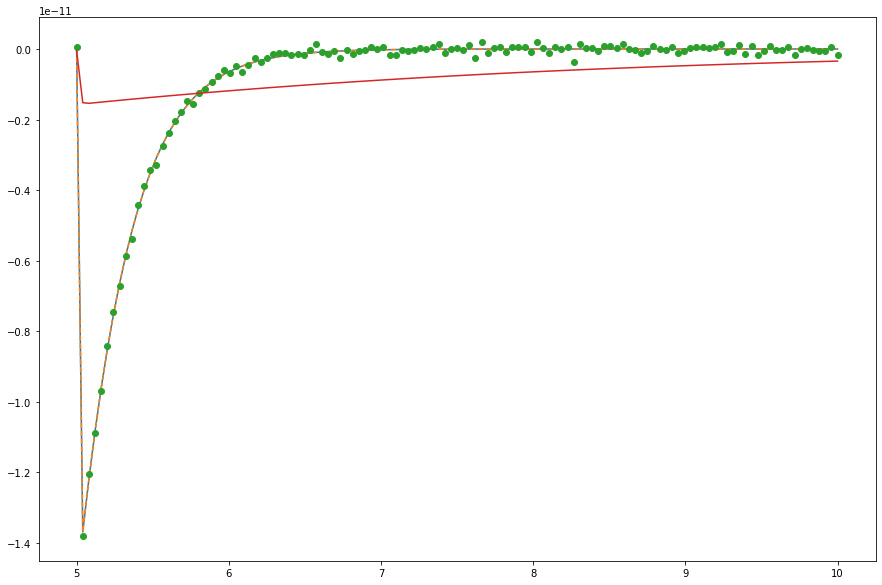

In [2]:
np.random.seed(1234)

### time steps
sample_rate = 25  # sample rate (x samples/sec)
stage_time = 5 # how long each experiment stage is (in sec)
t1 = np.linspace(0,stage_time,int(sample_rate*stage_time))
t2 = np.linspace(stage_time,2*stage_time,int(sample_rate*stage_time))
t3 = np.linspace(2*stage_time,3*stage_time,int(sample_rate*stage_time))
t_tot = np.hstack([t1,t2,t3])
t_23 = np.hstack([t2,t3])

### initial concentrations
y0 = np.array([
    1e-7,
    1e-3,
    2.833e-08,
    2.125e-08,
    2.833e-08,
    2.833e-08,
    2.125e-08,
    2.125e-08,
    2.125e-08,
    2.833e-08,
])

### experimental buffer concentrations
b1 = np.array([1e-07, 0.001])
b2 = np.array([5e-08, 0.001])
b3 = np.array([1e-07, 0.001])

### rate constants
k_H_on = 1e10
k_H_off = 1e3
k_S_on = 1e7
k_S_off = 1e3
k_conf = 1e2
theta = np.array([
    np.log10(k_H_on),
    np.log10(k_H_off),
    np.log10(k_S_off),
    np.log10(k_S_on),
    np.log10(k_conf),
    np.log10(k_conf),
    np.log10(k_conf),
    np.log10(k_conf),
    np.log10(k_S_on),  
    np.log10(k_S_off),  
    np.log10(k_H_off),  
])
std_true = 1e-13

### integrate multiple experiments
s1 = odeint(transporter_1c, y0=y0, t=t1, args=(theta,b1), atol=1e-16, rtol=1e-14)
s2 = odeint(transporter_1c, y0=s1[-1],t=t2, args=(theta,b2), atol=1e-16, rtol=1e-14)
s3 = odeint(transporter_1c, y0=s2[-1],t=t3, args=(theta,b3), atol=1e-16, rtol=1e-14)
#D = np.transpose(np.vstack([s2,s3]))
D = np.transpose(np.vstack([s2]))

s1_v2 = odeint(transporter_s1, y0=y0, t=t1, args=(theta,), atol=1e-16, rtol=1e-14)
s2_v2 = odeint(transporter_s2, y0=s1_v2[-1], t=t2, args=(theta,), atol=1e-16, rtol=1e-14)
s3_v2 = odeint(transporter_s1, y0=s2_v2[-1], t=t3, args=(theta,), atol=1e-16, rtol=1e-14)
#D_v2 = np.transpose(np.vstack([s2_v2,s3_v2]))
D_v2 = np.transpose(np.vstack([s2_v2]))

# vol*(rxn12_k1*IF_Hb_Sb-rxn12_k2*IF_Sb*H_in)
y_true = np.array((0.0001*(1e3*D[9]-1e10*D[7]*D[0])))
y_true2 = np.array((0.0001*(1e3*D_v2[9]-1e10*D_v2[7]*D_v2[0])))
noise = np.random.normal(0,std_true, np.size(y_true))
y_obs = y_true + noise 
plt.figure(figsize=(15,10))
# plt.plot(t_23, y_true)
# plt.plot(t_23, y_true2, '--')
# plt.plot(t_23, y_obs, 'o')
plt.plot(t2, y_true)
plt.plot(t2, y_true2, '--')
plt.plot(t2, y_obs, 'o')


### test
theta_test = [
    9.0,
    2.0,
    2.0,
    6.0,
    1.0,
    1.0,
    1.0,
    1.0,
    6.0,
    2.0,
    2.0,
]
s1_v3 = odeint(transporter_s1, y0=y0, t=t1, args=(theta_test,), atol=1e-16, rtol=1e-14)
s2_v3 = odeint(transporter_s2, y0=s1_v3[-1], t=t2, args=(theta_test,), atol=1e-16, rtol=1e-14)
#s3_v3 = odeint(transporter_s1, y0=s2_v3[-1], t=t3, args=(theta_test,), atol=1e-16, rtol=1e-14)
#D_v3 = np.transpose(np.vstack([s2_v3,s3_v3]))
D_v3 = np.transpose(np.vstack([s2_v3]))
log_12_k2_test = (theta_test[0]+theta_test[2]+theta_test[4]+theta_test[6]+theta_test[8]*+theta_test[10]) - (theta_test[1]+theta_test[3]+theta_test[5]+theta_test[7]+theta_test[9])
#print(s1_v3[-1])
#print(s2_v3[-1])
#print(f'stage 3 [-1]:{s3_v3[-1]}')
#print(f'data [-1]: {D_v3[-1]}')
y_true3 = np.array((0.0001*(1e2*D_v3[9]-1e9*D_v3[7]*D_v3[0])))
#print(f'y_pred true: {y_true3}')
#print(f'k12_2 true: {log_12_k2_test}')
plt.plot(t2, y_true3)

#### configure and run Bayesian inference 

In [3]:

### Bayesian inferennce
ode_model_s1 = DifferentialEquation(func=transporter_s1, times=t1, n_states=10, n_theta=11, t0=t1[0])
ode_model_s2 = DifferentialEquation(func=transporter_s2, times=t2, n_states=10, n_theta=11, t0=t2[0])

#ode_model_s3 = DifferentialEquation(func=transporter_s1, times=t3, n_states=10, n_theta=11, t0=t3[0])

# ode_model_s1 = DifferentialEquationWTol(func=transporter_s1, times=t1, n_states=10, n_theta=11, t0=t1[0])
# ode_model_s2 = DifferentialEquationWTol(func=transporter_s2, times=t2, n_states=10, n_theta=11, t0=t2[0])

flux_trace_list = []
with pm.Model() as model:

    # Specify prior distributions for our model parameters
    stdev_sample = pm.Uniform("noise_stdev", std_true*0.55, std_true*1.55)

    s=1  # shift priors so the true value isn't centered
    log_rxn2_k1 = pm.Uniform("log_rxn2_k1", 7-s, 13-s)
    log_rxn2_k2 = pm.Uniform("log_rxn2_k2", 0-s, 6-s)
    log_rxn3_k1 = pm.Uniform("log_rxn3_k1", 0-s, 6-s)
    log_rxn3_k2 = pm.Uniform("log_rxn3_k2", 4-s, 10-s)
    log_rxn4_k1 = pm.Uniform("log_rxn4_k1", -1-s, 5-s)
    log_rxn4_k2 = pm.Uniform("log_rxn4_k2", -1-s, 5-s)
    log_rxn6_k1 = pm.Uniform("log_rxn6_k1", -1-s, 5-s)
    log_rxn6_k2 = pm.Uniform("log_rxn6_k2", -1-s, 5-s)
    log_rxn11_k1 = pm.Uniform("log_rxn11_k1", 4-s, 10-s)
    log_rxn11_k2 = pm.Uniform("log_rxn11_k2", 0-s, 6-s)
    log_rxn12_k1 = pm.Uniform("log_rxn12_k1", 0-s, 6-s)
    log_rxn12_k2 = pm.Deterministic('log_rxn12_k2', ((log_rxn2_k1+log_rxn3_k1+log_rxn4_k1+log_rxn6_k1+log_rxn11_k1+log_rxn12_k1)-(log_rxn2_k2+log_rxn3_k2+log_rxn4_k2+log_rxn6_k2+log_rxn11_k2)))
    theta_sample = [
        log_rxn2_k1, 
        log_rxn2_k2,
        log_rxn3_k1, 
        log_rxn3_k2,
        log_rxn4_k1, 
        log_rxn4_k2,
        log_rxn6_k1, 
        log_rxn6_k2,
        log_rxn11_k1, 
        log_rxn11_k2,
        log_rxn12_k1, 
    ]

    # If we know one of the parameter values, we can simply pass the value.
    D_s1 = ode_model_s1(y0=y0, theta=theta_sample)
    D_s2 = ode_model_s2(y0=D_s1[-1], theta=theta_sample)
    # D_s3 = ode_model_s3(y0=D_s2[-1], theta=theta_sample)
    # theano.tensor.printing.Print('theta 0')(theta_sample[0])
    #D_sample = pm.math.concatenate([theano.tensor.transpose(D_s2),theano.tensor.transpose(D_s3)], axis=1)
    D_sample = theano.tensor.transpose(D_s2)
    vol = 0.0001 # check this ? 
    # y_pred = pm.Deterministic('y_pred', (vol*(((10**log_rxn12_k1)*D_sample[9])- ((10**log_rxn12_k2)*D_sample[0]*D_sample[7]))) )
    y_pred = (vol*(((10**log_rxn12_k1)*D_sample[9])-((10**log_rxn12_k2)*D_sample[0]*D_sample[7])))
    Y = pm.Normal("Y", mu=y_pred, sigma=stdev_sample, observed=y_obs)
    trace = pm.sample(1000, tune=100, chains=1)
    data = az.from_pymc3(trace=trace)

# plot results
az.plot_trace(data)
az.plot_posterior(data)

/var/folders/n9/ypwpwtxs29dgh8ycr8xkgcp0n7tvkv/T/ipykernel_50674/3060110863.py:54: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(1000, tune=100, chains=1)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [log_rxn12_k1, log_rxn11_k2, log_rxn11_k1, log_rxn6_k2, log_rxn6_k1, log_rxn4_k2, log_rxn4_k1, log_rxn3_k2, log_rxn3_k1, log_rxn2_k2, log_rxn2_k1, noise_stdev]


/opt/miniconda3/envs/pymc3_sunode_env/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+01   r2 =  0.5961401946259D-40
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+01   r2 =  0.5961401946259D-40
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+01   r2 =  0.1965446476355D-38
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+01   r2 =  0.1965446476355D-38
 lsoda--  warning..internal t (=r1) 

/opt/miniconda3/envs/pymc3_sunode_env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/miniconda3/envs/pymc3_sunode_env/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Sampling 1 chain for 38 tune and 0 draw iterations (38 + 0 draws total) took 4996 seconds.
No posterior samples. Unable to run convergence checks


ValueError: Can not extract posterior from Inference data with groups:
	> observed_data! See /opt/miniconda3/envs/pymc3_sunode_env/lib/python3.9/site-packages/arviz/data/converters.py for other conversion utilities.

In [2]:
import numpy as np
sample_rate = 25  # sample rate (x samples/sec)
stage_time = 5 # how long each experiment stage is (in sec)
t1 = np.linspace(0,stage_time,int(sample_rate*stage_time), endpoint=False)
t2 = np.linspace(stage_time,2*stage_time,int(sample_rate*stage_time), endpoint=False)
t3 = np.linspace(2*stage_time,3*stage_time,int(sample_rate*stage_time),endpoint=False)

print(t1)
print(t2)

[0.   0.04 0.08 0.12 0.16 0.2  0.24 0.28 0.32 0.36 0.4  0.44 0.48 0.52
 0.56 0.6  0.64 0.68 0.72 0.76 0.8  0.84 0.88 0.92 0.96 1.   1.04 1.08
 1.12 1.16 1.2  1.24 1.28 1.32 1.36 1.4  1.44 1.48 1.52 1.56 1.6  1.64
 1.68 1.72 1.76 1.8  1.84 1.88 1.92 1.96 2.   2.04 2.08 2.12 2.16 2.2
 2.24 2.28 2.32 2.36 2.4  2.44 2.48 2.52 2.56 2.6  2.64 2.68 2.72 2.76
 2.8  2.84 2.88 2.92 2.96 3.   3.04 3.08 3.12 3.16 3.2  3.24 3.28 3.32
 3.36 3.4  3.44 3.48 3.52 3.56 3.6  3.64 3.68 3.72 3.76 3.8  3.84 3.88
 3.92 3.96 4.   4.04 4.08 4.12 4.16 4.2  4.24 4.28 4.32 4.36 4.4  4.44
 4.48 4.52 4.56 4.6  4.64 4.68 4.72 4.76 4.8  4.84 4.88 4.92 4.96]
[5.   5.04 5.08 5.12 5.16 5.2  5.24 5.28 5.32 5.36 5.4  5.44 5.48 5.52
 5.56 5.6  5.64 5.68 5.72 5.76 5.8  5.84 5.88 5.92 5.96 6.   6.04 6.08
 6.12 6.16 6.2  6.24 6.28 6.32 6.36 6.4  6.44 6.48 6.52 6.56 6.6  6.64
 6.68 6.72 6.76 6.8  6.84 6.88 6.92 6.96 7.   7.04 7.08 7.12 7.16 7.2
 7.24 7.28 7.32 7.36 7.4  7.44 7.48 7.52 7.56 7.6  7.64 7.68 7.72 7.76
 7.8  7.84 7